In [1]:
import gc
import time
import keras as k
import numpy as np
import pandas as pd
import sklearn as sk
import datetime as dt
import keras.backend as K
import matplotlib.pyplot as plt

from keras import regularizers
from keras.models import Model
from keras.layers import Input, Dense, Activation
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.metrics import mean_squared_error, mean_absolute_error, \
                confusion_matrix, classification_report

# custom Fuzzy Layers
from sofenn import SOFNN
from sofenn.layers import FuzzyLayer, NormalizedLayer, WeightedLayer, OutputLayer

pd.set_option('display.max_columns', None)

Using TensorFlow backend.


# Inspecting Data

In [2]:
df = pd.read_csv('../data/btc_dataset.csv',index_col='date')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1763 entries, 12/27/13 to 10/24/18
Columns: 132 entries, com_count to bitcoin_market_cap
dtypes: float64(64), int64(68)
memory usage: 1.8+ MB


In [3]:
df.head()

,com_count,sub_count,com_body_pos_count,com_body_very_pos_count,com_body_neg_count,com_body_very_neg_count,sub_body_pos_count,sub_body_very_pos_count,sub_body_neg_count,sub_body_very_neg_count,sub_title_pos_count,sub_title_very_pos_count,sub_title_neg_count,sub_title_very_neg_count,sub_title_non_zero_pr,sub_title_top_50_pr,sub_title_top_75_pr,sub_title_pr_4_bins,sub_title_pr_normalized,sub_title_pr_norm_plus_base,sub_title_pos_non_zero_pr,sub_title_pos_top_50_pr,sub_title_pos_top_75_pr,sub_title_pos_pr_4_bins,sub_title_pos_pr_normalized,sub_title_pos_pr_norm_plus_base,sub_title_very_pos_non_zero_pr,sub_title_very_pos_top_50_pr,sub_title_very_pos_top_75_pr,sub_title_very_pos_pr_4_bins,sub_title_very_pos_pr_normalized,sub_title_very_pos_pr_norm_plus_base,sub_title_neg_non_zero_pr,sub_title_neg_top_50_pr,sub_title_neg_top_75_pr,sub_title_neg_pr_4_bins,sub_title_neg_pr_normalized,sub_title_neg_pr_norm_plus_base,sub_title_very_neg_non_zero_pr,sub_title_very_neg_top_50_pr,sub_title_very_neg_top_75_pr,sub_title_very_neg_pr_4_bins,sub_title_very_neg_pr_normalized,sub_title_very_neg_pr_norm_plus_base,sub_title_very_pos_minus_very_neg_non_zero_pr,sub_title_pos_minus_neg_non_zero_pr,sub_title_pos_non_zero_pr_percent,sub_title_very_pos_non_zero_pr_percent,sub_title_neg_non_zero_pr_percent,sub_title_very_neg_non_zero_pr_percent,sub_body_non_zero_pr,sub_body_top_50_pr,sub_body_top_75_pr,sub_body_pr_4_bins,sub_body_pr_normalized,sub_body_pr_norm_plus_base,sub_body_pos_non_zero_pr,sub_body_pos_top_50_pr,sub_body_pos_top_75_pr,sub_body_pos_pr_4_bins,sub_body_pos_pr_normalized,sub_body_pos_pr_norm_plus_base,sub_body_very_pos_non_zero_pr,sub_body_very_pos_top_50_pr,sub_body_very_pos_top_75_pr,sub_body_very_pos_pr_4_bins,sub_body_very_pos_pr_normalized,sub_body_very_pos_pr_norm_plus_base,sub_body_neg_non_zero_pr,sub_body_neg_top_50_pr,sub_body_neg_top_75_pr,sub_body_neg_pr_4_bins,sub_body_neg_pr_normalized,sub_body_neg_pr_norm_plus_base,sub_body_very_neg_non_zero_pr,sub_body_very_neg_top_50_pr,sub_body_very_neg_top_75_pr,sub_body_very_neg_pr_4_bins,sub_body_very_neg_pr_normalized,sub_body_very_neg_pr_norm_plus_base,sub_body_very_pos_minus_very_neg_non_zero_pr,sub_body_pos_minus_neg_non_zero_pr,sub_body_pos_non_zero_pr_percent,sub_body_very_pos_non_zero_pr_percent,sub_body_neg_non_zero_pr_percent,sub_body_very_neg_non_zero_pr_percent,com_body_non_zero_pr,com_body_top_50_pr,com_body_top_75_pr,com_body_pr_4_bins,com_body_pr_normalized,com_body_pr_norm_plus_base,com_body_pos_non_zero_pr,com_body_pos_top_50_pr,com_body_pos_top_75_pr,com_body_pos_pr_4_bins,com_body_pos_pr_normalized,com_body_pos_pr_norm_plus_base,com_body_very_pos_non_zero_pr,com_body_very_pos_top_50_pr,com_body_very_pos_top_75_pr,com_body_very_pos_pr_4_bins,com_body_very_pos_pr_normalized,com_body_very_pos_pr_norm_plus_base,com_body_neg_non_zero_pr,com_body_neg_top_50_pr,com_body_neg_top_75_pr,com_body_neg_pr_4_bins,com_body_neg_pr_normalized,com_body_neg_pr_norm_plus_base,com_body_very_neg_non_zero_pr,com_body_very_neg_top_50_pr,com_body_very_neg_top_75_pr,com_body_very_neg_pr_4_bins,com_body_very_neg_pr_normalized,com_body_very_neg_pr_norm_plus_base,com_body_very_pos_minus_very_neg_non_zero_pr,com_body_pos_minus_neg_non_zero_pr,com_body_pos_non_zero_pr_percent,com_body_very_pos_non_zero_pr_percent,com_body_neg_non_zero_pr_percent,com_body_very_neg_non_zero_pr_percent,avg_clust_coef,avg_degree,num_edges,num_nodes,bitcoin_open,bitcoin_high,bitcoin_low,bitcoin_close,bitcoin_volume,bitcoin_market_cap
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12/27/13,6065,477,1516,766,666,253,105,74,14,6,67,10,22,4,151,15,1,96.25,0.584285,4.434285,14,3,0,13.0,0.075103,0.595103,1,0,0,1.75,0.000659,0.070659,9,1,0,4.25,0.025917,0.195917,1,0,0,0.75,0.000924,0.030924,0,5,0.092715,0.006623,0.059603,0.006623,151,15,1,96.25,0.584285,4.434285,36,2,0,21.00,0.107567,0.947567,27,1,0,14.00,0.072764,0.632764,2,0,0,2.75,0.00

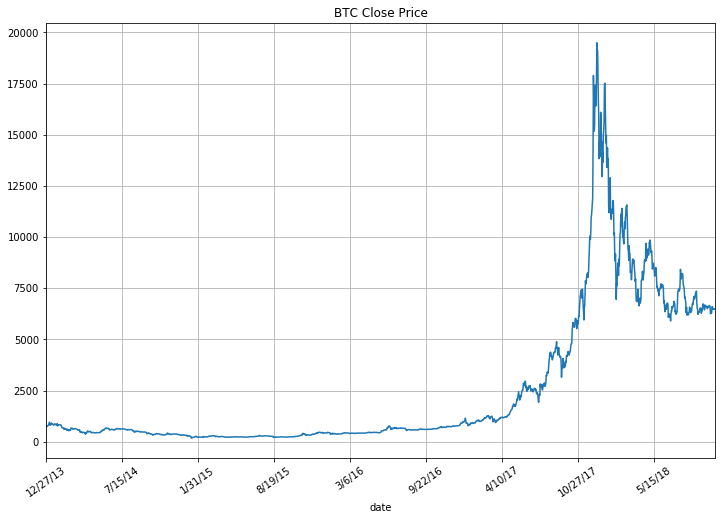

In [4]:
# show closing price time series
df['bitcoin_close'].plot(title='BTC Close Price',grid=True,rot=35, figsize=(12,8))

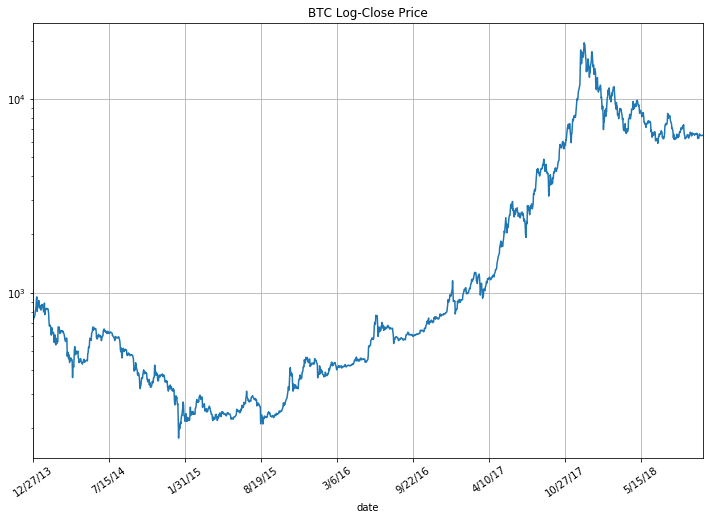

In [5]:
# show log-closing price time series
df['bitcoin_close'].plot(title='BTC Log-Close Price',grid=True,logy=True,rot=35, figsize=(12,8))

In [6]:
# stats on time series length
print("number of days:  {:.1f}".format(df.shape[0]))
print("number of months:  {:.1f}".format(df.shape[0] / 30))
print("number of years:    {:.1f}".format(df.shape[0] / 365))

number of days:  1763.0
number of months:  58.8
number of years:    4.8


# Defining Functions

## Loading and Preparing Data

In [7]:
# function to read in dataset

def get_data(curr='btc'):
    if curr.lower() not in ['btc', 'eth']:
        raise ValueError('Must be BTC or ETH')
    return pd.read_csv('../data/{}_dataset.csv'.format(curr.lower()), index_col='date')

In [8]:
# function to drop unneeded fields

def keep_only_close(df_in, curr='btc'):
    if curr.lower() == 'btc':
        drops = ['bitcoin_open', 'bitcoin_high', 'bitcoin_low',
                 'bitcoin_volume', 'bitcoin_market_cap']
    elif curr.lower() == 'eth':
        drops = ['eth_open', 'eth_high', 'eth_low',
                 'eth_volume', 'eth_market_cap']
    else:
        raise ValueError('Must be BTC or ETH for lags')
    return df_in.drop(drops, axis=1) 

In [9]:
# function to add predicted column for tomorrow's close price

def add_prediction_field(df_in, curr='btc'):
    if curr.lower() == 'btc':
        name = 'bitcoin'
    elif curr.lower() == 'eth':
        name = 'eth'
    else:
        raise ValueError('Must be BTC or ETH for lags')
    
    # creating predicted value
    # create column to hold tomorrow's close for each day
    df_in['tomorrow_close'] = df_in['{}_close'.format(name)].shift(-1)
    # change in price between consecutive closing days
    df_in['day_change'] = df_in['tomorrow_close'] - df_in['{}_close'.format(name)]
    # indicator variable to be used for predicting higher/lower days
    df_in['y'] = np.where(df_in['day_change'] >= 0, 1, 0)
        
    # drop intermediate columns
    return df_in.drop(['tomorrow_close', 'day_change'], axis=1)

In [10]:
# function to retrieve lag values to use for each feature

def get_feature_lag_dict(curr='btc'):
    # check value of input
    if curr.lower() not in ['btc', 'eth']:
        raise ValueError('Must be BTC or ETH for lags')
    
    # read in right version of file
    df = pd.read_csv('../lags/optimal_lags_{}.csv'.format(curr.lower()))
    
    # return dictionary of features as keys and lags as values
    return dict(zip(df.feature, df.lags))

In [11]:
# function to add lags for daily features

def add_lags(df_in, curr='btc'):
    # splitting into X/y for separate processing
    X, y = df_in[df_in.columns[:-1]], df_in[df_in.columns[-1]]
    # save list of columns for lags
    col_list = X.columns
    # create output DF
    df_out = X.copy()
    
    # creating lags
    f_dict = get_feature_lag_dict(curr=curr)
    # create lag columns for each other variable
    for col in col_list:
        if col not in f_dict.keys(): continue
        for lag in range(int(f_dict[col])):
            df_out['{}_(-{})'.format(col,lag+1)] = df_out[col].shift(lag+1)

    # return and drop na
    df_out['y'] = y
    return df_out.dropna()

In [12]:
# function to remove data before certain date

def truncate_date(df_in, first_day='1999-1-1'):
    # set mask of Bool values
    mask = (pd.to_datetime(df_in.index) >= first_day)
    return df_in.loc[mask]

In [13]:
# function to rejoin training data into X/y again

def rejoin_training_data(X_train, X_test, y_train, y_test):
    Xs = [X_train, X_test]
    Ys = [y_train, y_test]
    
    df_out = pd.concat(Xs)
    df_out['y'] = pd.concat(Ys)
    
    return df_out

In [14]:
# function to create train/test X and y
def create_training_data(df_in, curr='btc', train_split=0.7, rescale=True, k_feat_perc=None):
    # split into test train
    X, y = df_in[df_in.columns[:-1]], df_in[df_in.columns[-1]]
    
    # determine cutoff of train/test split and split
    cutoff = int(X.shape[0] * train_split)
    X_train, y_train = X[:cutoff], y[:cutoff]
    X_test, y_test = X[cutoff:], y[cutoff:]
    
    # scale values to 0-1
    # must only scale based on training data, to ensure no 
    # foresight with averages
    if rescale:
        scaler = MinMaxScaler(feature_range=(0,1)).fit(X_train.values)
        cols = X.columns
        X_train = pd.DataFrame(scaler.transform(X_train.values), 
                               index=X_train.index, columns=cols)
        X_test = pd.DataFrame(scaler.transform(X_test.values), 
                               index=X_test.index, columns=cols)
    
    # select top K features to use
    if k_feat_perc:
        selector = SelectPercentile(chi2, percentile=k_feat_perc).fit(
                                    X_train.values,y_train.values)
        # index and names of remainig columns after filter
        cols = X_train.columns[selector.get_support(indices = True)]
        X_train = pd.DataFrame(selector.transform(X_train.values), 
                               index=X_train.index, columns=cols)
        X_test = pd.DataFrame(selector.transform(X_test.values), 
                               index=X_test.index, columns=cols)
    
    # recreate into X/y DF and add lags
    df_renew = rejoin_training_data(X_train, X_test, y_train, y_test)
    df_renew = add_lags(df_renew, curr=curr)
    
    # split into test train again
    X, y = df_renew[df_renew.columns[:-1]], df_renew[df_renew.columns[-1]]
    cutoff = int(X.shape[0] * train_split)
    X_train, y_train = X[:cutoff], y[:cutoff]
    X_test, y_test = X[cutoff:], y[cutoff:]

    # display shapes
    print('='*65)
    print('New Training Set')
    print('Training Set Dims: {}'.format(X_train.shape))
    print('Testing Set Dims:  {}'.format(X_test.shape))
    print('='*65)

    return X_train, X_test, y_train, y_test

In [15]:
# function to prep data and return DF for modeling

def prepare_data(curr='btc',train_split=0.7, close_o=False, 
                         first_day=None, rescale=True, k_feat_perc=None):
    # read in  dataset and initialize output df
    df_in = get_data(curr)
    
    # drop non-price fields if needed
    if close_o:
        df_in = keep_only_close(df_in, curr=curr)
    
    # add prediction field
    df_in = add_prediction_field(df_in, curr=curr)
    
    # cut off prior to first_day
    if first_day:
        df_in = truncate_date(df_in, first_day)
    
    return create_training_data(df_in, curr=curr, train_split=train_split, 
                                rescale=rescale, k_feat_perc=k_feat_perc)

## Preparing Data for Training

In [16]:
# split dataset
X_train, X_test, y_train, y_test = prepare_data(curr='btc', train_split=0.8, close_o=False, 
                                    first_day='2016-1-1', rescale=True, k_feat_perc=50)

New Training Set
Training Set Dims: (749, 263)
Testing Set Dims:  (84, 263)


In [17]:
X_train.shape

(749, 263)

In [18]:
X_test.shape

(84, 263)

In [19]:
y_train.shape

(749,)

In [20]:
y_test.shape

(84,)

In [21]:
# balance of dependent variable values
ones = y_train.sum()
zeros = y_train.shape[0] - ones
print("0's: {}".format(zeros))
print("1's: {}".format(ones))

0's: 316
1's: 433


In [22]:
# balance of dependent variable values
ones = y_test.sum()
zeros = y_test.shape[0] - ones
print("0's: {}".format(zeros))
print("1's: {}".format(ones))

0's: 43
1's: 41


## Build, Train, Test SOFNN Model

In [23]:
sofnn = SOFNN(X_train, X_test, y_train, y_test)


BUILDING SOFNN WITH 1 NEURONS
Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             (None, 263)          0                                            
__________________________________________________________________________________________________
FuzzyRules (FuzzyLayer)         (None, 1)            526         Inputs[0][0]                     
__________________________________________________________________________________________________
Normalization (NormalizedLayer) (None, 1)            0           FuzzyRules[0][0]                 
__________________________________________________________________________________________________
Weights (WeightedLayer)         (None, 1)            264         Inputs[0][0]                     
      

Instructions for updating:
Use tf.cast instead.
84/84 [==============================] - 0s 547us/step

Accuracy Measures
Accuracy:  52.38%
MAPE:      47.62%
AUC Score: 50.48%

Confusion Matrix
          pred:no  pred:yes
true:no        26        17
true:yes       23        18

Classification Report
              precision    recall  f1-score   support

           0       0.53      0.60      0.57        43
           1       0.51      0.44      0.47        41

   micro avg       0.52      0.52      0.52        84
   macro avg       0.52      0.52      0.52        84
weighted avg       0.52      0.52      0.52        84



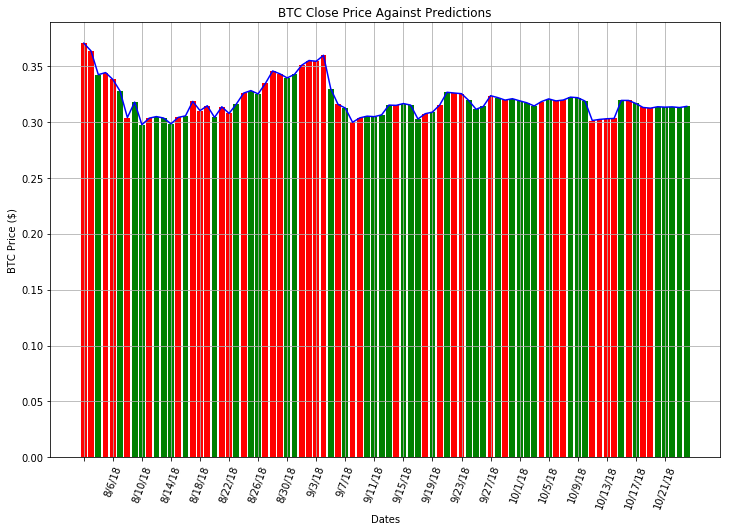

In [24]:
sofnn._train_model()
y_pred = sofnn._evaluate_model()

In [25]:
# function to create and train model

def run_model(rules=5, batch_size = 1, epochs=5):
    # get shape of training data
    samples, feats = X_train.shape
    
    # add layers
    inputs = Input(name='Inputs',shape=(feats,))
    fuzz = FuzzyLayer(rules)
    norm = NormalizedLayer(rules)
    weights = WeightedLayer(rules)
    raw = OutputLayer()
    
    # run through layers
    phi = fuzz(inputs)
    psi = norm(phi)
    f = weights([inputs, psi])
    raw_output = raw(f)
    #raw_output = Dense(1, name='RawOutput', activation='linear', use_bias=False)(f)
    preds = Activation(name='OutputActivation', activation='sigmoid')(raw_output)
    
    # compile model and output summary 
    model = Model(inputs=inputs, outputs=preds)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    # fit model and evaluate
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,shuffle=False)
    scores = model.evaluate(X_test, y_test, verbose=1)
    accuracy = scores[1] * 100
    print("\nAccuracy: {:.2f}%".format(accuracy))
    
    # print confusion matrix
    print('\nConfusion Matrix')
    print('='*20)
    y_pred = np.squeeze(np.where(model.predict(X_test) >= 0.5, 1, 0), axis=-1)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred), 
                       index=['true:no', 'true:yes'], columns=['pred:no', 'pred:yes']))
    
    # print classification report
    print('\nClasification Report')
    print('='*20)
    print(classification_report(y_test, y_pred, labels=[0,1]))
    
    return model, y_pred

In [26]:
# test out various nodes
for rule in [5]:
    print('{} Rules'.format(rule))
    model, y_pred = run_model(rules=rule, batch_size=30, epochs=50)

5 Rules
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             (None, 263)          0                                            
__________________________________________________________________________________________________
FuzzyRules (FuzzyLayer)         (None, 5)            2630        Inputs[0][0]                     
__________________________________________________________________________________________________
Normalization (NormalizedLayer) (None, 5)            0           FuzzyRules[0][0]                 
__________________________________________________________________________________________________
Weights (WeightedLayer)         (None, 5)            1320        Inputs[0][0]                     
                                                                 Normalization[0][0]              
__

## Testing Model Attributes

### 1 Initial Neuron


BUILDING SOFNN WITH 1 NEURONS
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             (None, 263)          0                                            
__________________________________________________________________________________________________
FuzzyRules (FuzzyLayer)         (None, 1)            526         Inputs[0][0]                     
__________________________________________________________________________________________________
Normalization (NormalizedLayer) (None, 1)            0           FuzzyRules[0][0]                 
__________________________________________________________________________________________________
Weights (WeightedLayer)         (None, 1)            264         Inputs[0][0]                     
                                                                 Normalization

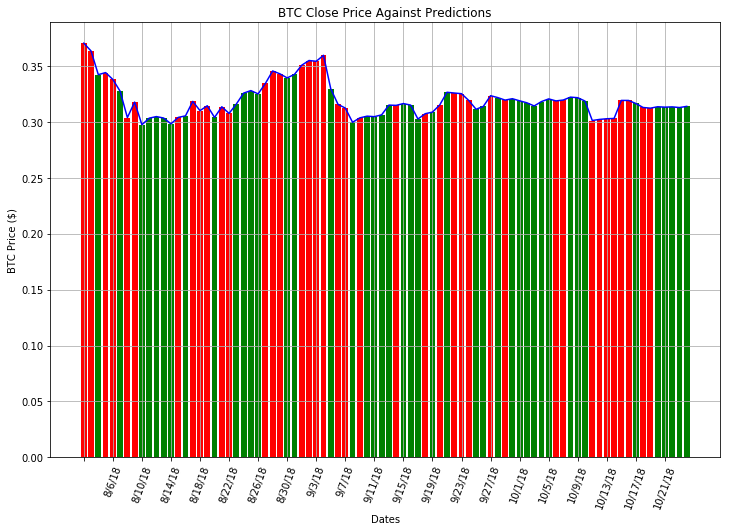


Self-Organization complete!
If-Part and Error Criterion satisfied

Final Evaluation
84/84 [==============================] - 0s 48us/step

Accuracy Measures
Accuracy:  52.38%
MAPE:      47.62%
AUC Score: 51.22%

Confusion Matrix
          pred:no  pred:yes
true:no        22        21
true:yes       19        22

Classification Report
              precision    recall  f1-score   support

           0       0.54      0.51      0.52        43
           1       0.51      0.54      0.52        41

   micro avg       0.52      0.52      0.52        84
   macro avg       0.52      0.52      0.52        84
weighted avg       0.52      0.52      0.52        84



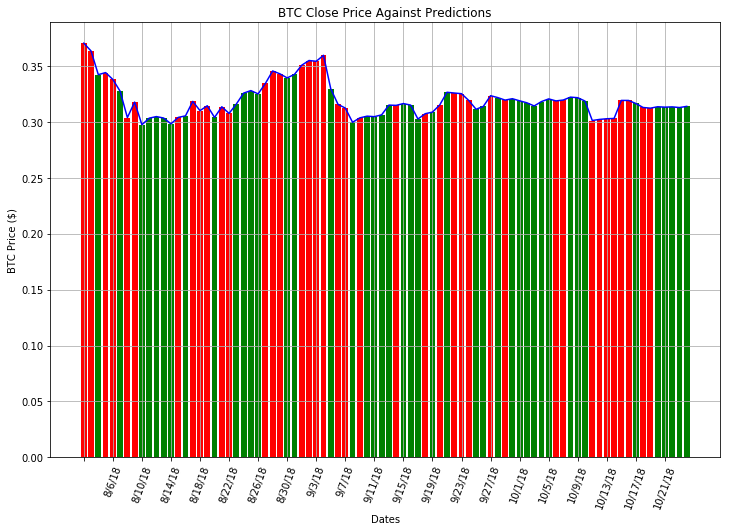

In [27]:
sofnn = SOFNN(X_train, X_test, y_train, y_test, neurons=1, 
              ksig=1.5, max_widens=250, prune_tol=0.85)
sofnn.self_organize()

### 2 Initial Neurons


BUILDING SOFNN WITH 2 NEURONS
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             (None, 263)          0                                            
__________________________________________________________________________________________________
FuzzyRules (FuzzyLayer)         (None, 2)            1052        Inputs[0][0]                     
__________________________________________________________________________________________________
Normalization (NormalizedLayer) (None, 2)            0           FuzzyRules[0][0]                 
__________________________________________________________________________________________________
Weights (WeightedLayer)         (None, 2)            528         Inputs[0][0]                     
                                                                 Normalization

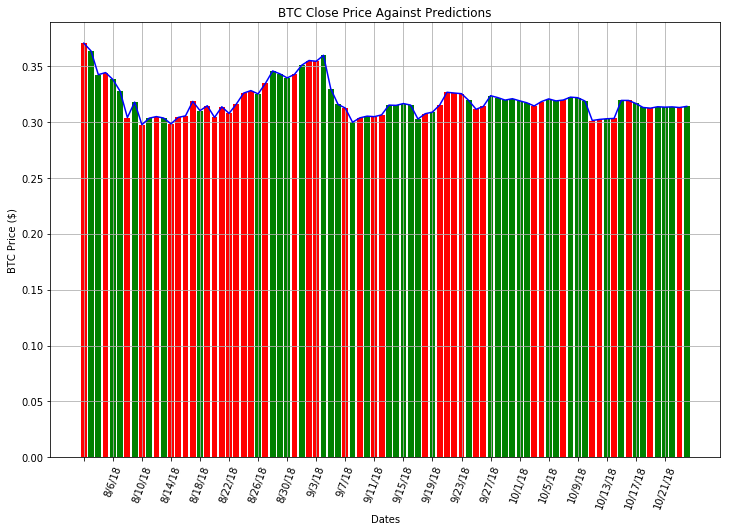


Widening centers...
Max iterations reached (250)

Adding neuron...

BUILDING SOFNN WITH 3 NEURONS
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             (None, 263)          0                                            
__________________________________________________________________________________________________
FuzzyRules (FuzzyLayer)         (None, 3)            1578        Inputs[0][0]                     
__________________________________________________________________________________________________
Normalization (NormalizedLayer) (None, 3)            0           FuzzyRules[0][0]                 
__________________________________________________________________________________________________
Weights (WeightedLayer)         (None, 3)            792         Inputs[0][0]                     
          

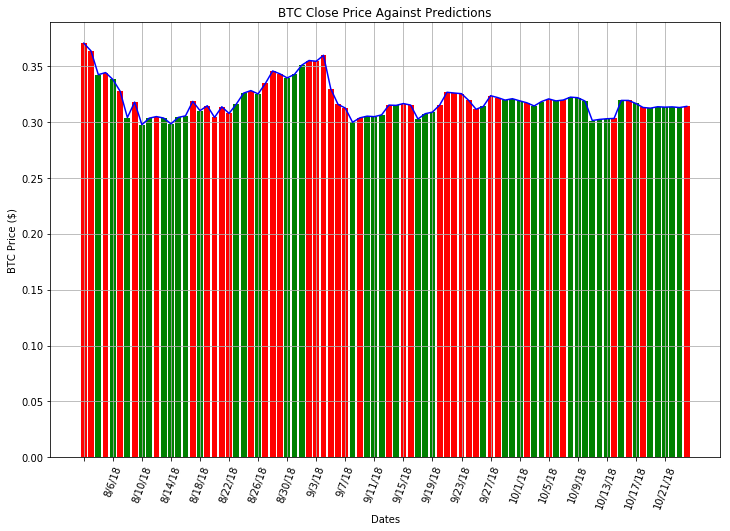


Widening centers...
Max iterations reached (250)

Adding neuron...

BUILDING SOFNN WITH 4 NEURONS
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             (None, 263)          0                                            
__________________________________________________________________________________________________
FuzzyRules (FuzzyLayer)         (None, 4)            2104        Inputs[0][0]                     
__________________________________________________________________________________________________
Normalization (NormalizedLayer) (None, 4)            0           FuzzyRules[0][0]                 
__________________________________________________________________________________________________
Weights (WeightedLayer)         (None, 4)            1056        Inputs[0][0]                     
          

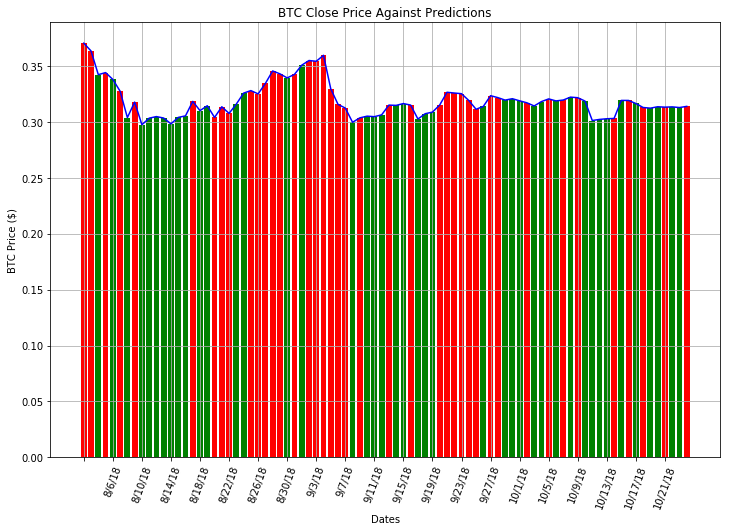


Widening centers...
Max iterations reached (250)

Adding neuron...

BUILDING SOFNN WITH 5 NEURONS
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             (None, 263)          0                                            
__________________________________________________________________________________________________
FuzzyRules (FuzzyLayer)         (None, 5)            2630        Inputs[0][0]                     
__________________________________________________________________________________________________
Normalization (NormalizedLayer) (None, 5)            0           FuzzyRules[0][0]                 
__________________________________________________________________________________________________
Weights (WeightedLayer)         (None, 5)            1320        Inputs[0][0]                     
          

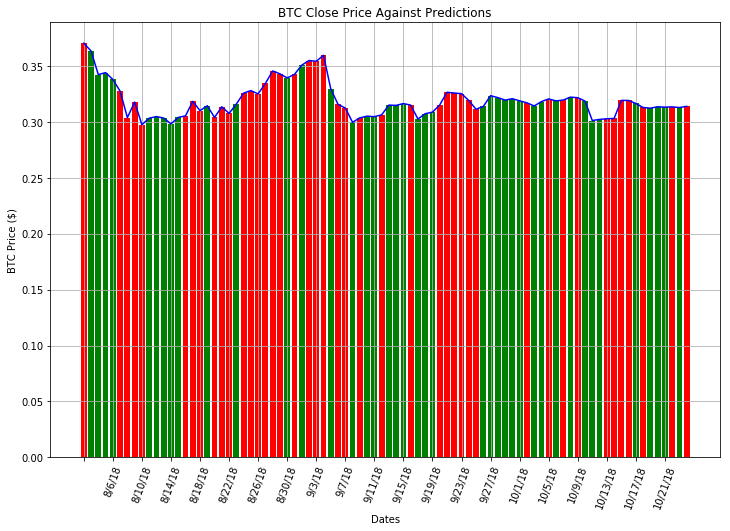


Widening centers...
Max iterations reached (250)

Adding neuron...

BUILDING SOFNN WITH 6 NEURONS
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             (None, 263)          0                                            
__________________________________________________________________________________________________
FuzzyRules (FuzzyLayer)         (None, 6)            3156        Inputs[0][0]                     
__________________________________________________________________________________________________
Normalization (NormalizedLayer) (None, 6)            0           FuzzyRules[0][0]                 
__________________________________________________________________________________________________
Weights (WeightedLayer)         (None, 6)            1584        Inputs[0][0]                     
          

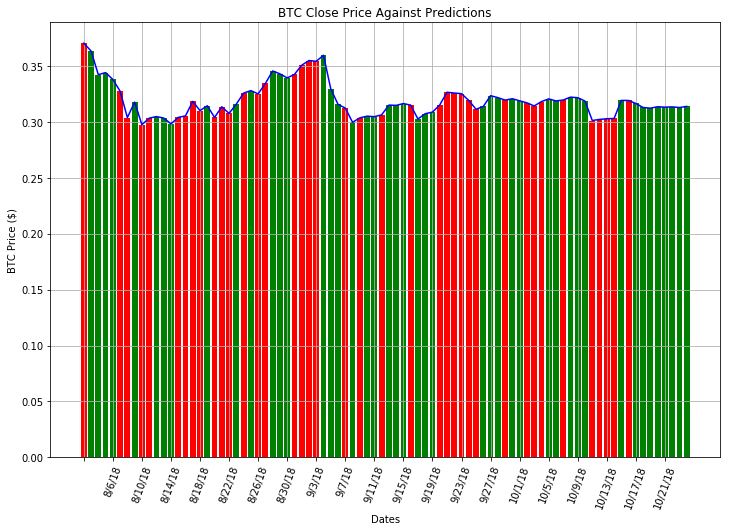


Widening centers...
Max iterations reached (250)

Adding neuron...

BUILDING SOFNN WITH 7 NEURONS
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             (None, 263)          0                                            
__________________________________________________________________________________________________
FuzzyRules (FuzzyLayer)         (None, 7)            3682        Inputs[0][0]                     
__________________________________________________________________________________________________
Normalization (NormalizedLayer) (None, 7)            0           FuzzyRules[0][0]                 
__________________________________________________________________________________________________
Weights (WeightedLayer)         (None, 7)            1848        Inputs[0][0]                     
          

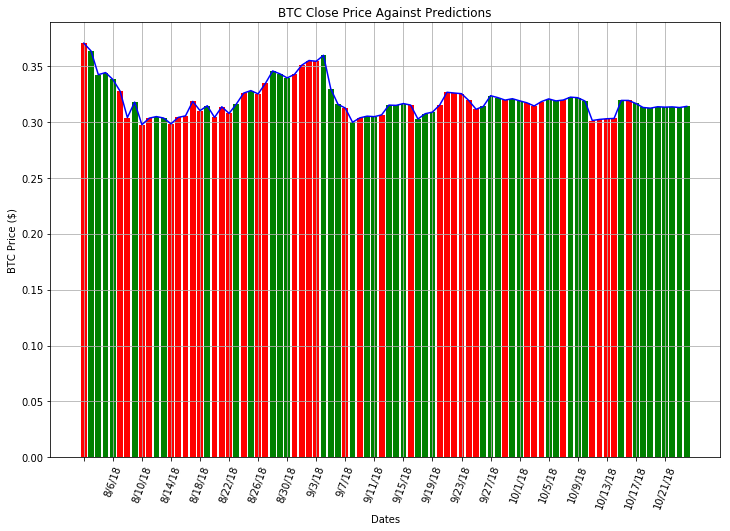


Widening centers...
Max iterations reached (250)

Adding neuron...

BUILDING SOFNN WITH 8 NEURONS
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             (None, 263)          0                                            
__________________________________________________________________________________________________
FuzzyRules (FuzzyLayer)         (None, 8)            4208        Inputs[0][0]                     
__________________________________________________________________________________________________
Normalization (NormalizedLayer) (None, 8)            0           FuzzyRules[0][0]                 
__________________________________________________________________________________________________
Weights (WeightedLayer)         (None, 8)            2112        Inputs[0][0]                     
          

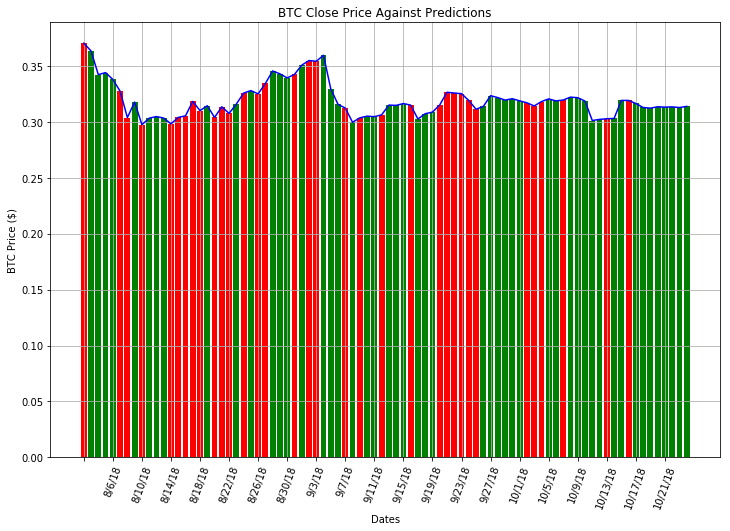


Widening centers...
Max iterations reached (250)

Adding neuron...

BUILDING SOFNN WITH 9 NEURONS
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             (None, 263)          0                                            
__________________________________________________________________________________________________
FuzzyRules (FuzzyLayer)         (None, 9)            4734        Inputs[0][0]                     
__________________________________________________________________________________________________
Normalization (NormalizedLayer) (None, 9)            0           FuzzyRules[0][0]                 
__________________________________________________________________________________________________
Weights (WeightedLayer)         (None, 9)            2376        Inputs[0][0]                     
          

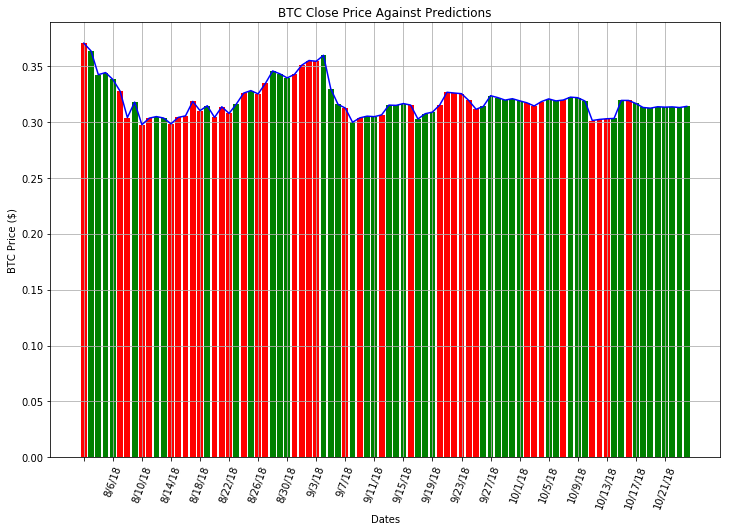


Widening centers...
Max iterations reached (250)

Adding neuron...

BUILDING SOFNN WITH 10 NEURONS
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             (None, 263)          0                                            
__________________________________________________________________________________________________
FuzzyRules (FuzzyLayer)         (None, 10)           5260        Inputs[0][0]                     
__________________________________________________________________________________________________
Normalization (NormalizedLayer) (None, 10)           0           FuzzyRules[0][0]                 
__________________________________________________________________________________________________
Weights (WeightedLayer)         (None, 10)           2640        Inputs[0][0]                     
         

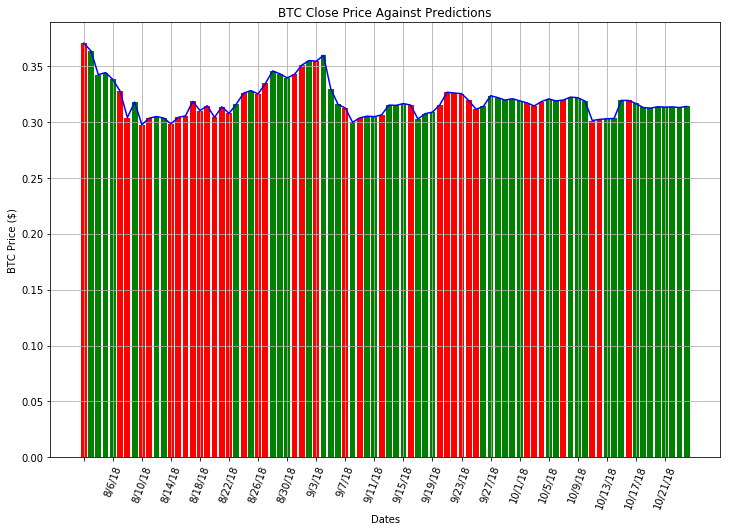


Widening centers...
Max iterations reached (250)

Adding neuron...

BUILDING SOFNN WITH 11 NEURONS
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             (None, 263)          0                                            
__________________________________________________________________________________________________
FuzzyRules (FuzzyLayer)         (None, 11)           5786        Inputs[0][0]                     
__________________________________________________________________________________________________
Normalization (NormalizedLayer) (None, 11)           0           FuzzyRules[0][0]                 
__________________________________________________________________________________________________
Weights (WeightedLayer)         (None, 11)           2904        Inputs[0][0]                     
         

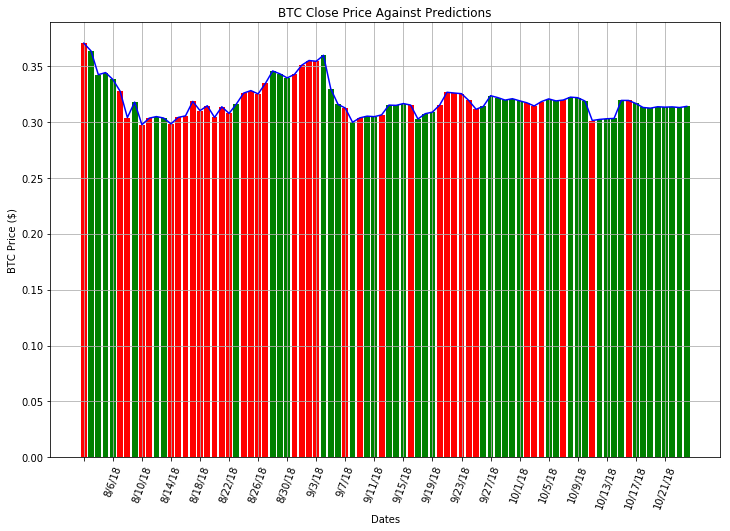


Widening centers...
Max iterations reached (250)

Adding neuron...

BUILDING SOFNN WITH 12 NEURONS
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             (None, 263)          0                                            
__________________________________________________________________________________________________
FuzzyRules (FuzzyLayer)         (None, 12)           6312        Inputs[0][0]                     
__________________________________________________________________________________________________
Normalization (NormalizedLayer) (None, 12)           0           FuzzyRules[0][0]                 
__________________________________________________________________________________________________
Weights (WeightedLayer)         (None, 12)           3168        Inputs[0][0]                     
         

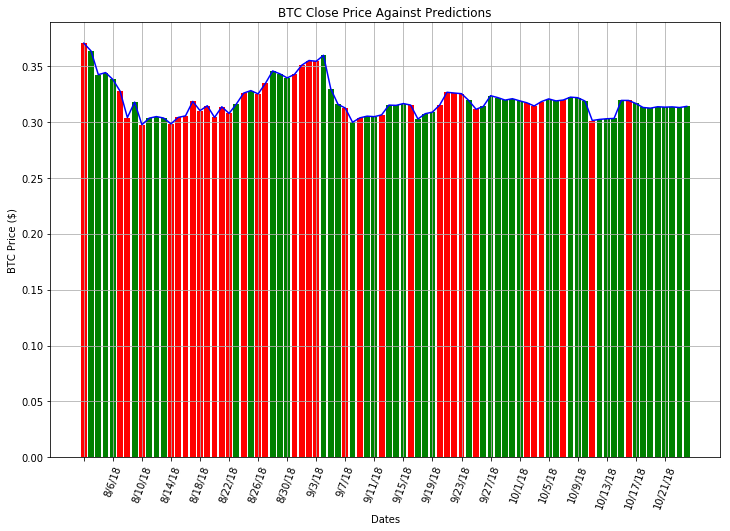


Widening centers...
Max iterations reached (250)

Adding neuron...

BUILDING SOFNN WITH 13 NEURONS
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             (None, 263)          0                                            
__________________________________________________________________________________________________
FuzzyRules (FuzzyLayer)         (None, 13)           6838        Inputs[0][0]                     
__________________________________________________________________________________________________
Normalization (NormalizedLayer) (None, 13)           0           FuzzyRules[0][0]                 
__________________________________________________________________________________________________
Weights (WeightedLayer)         (None, 13)           3432        Inputs[0][0]                     
         

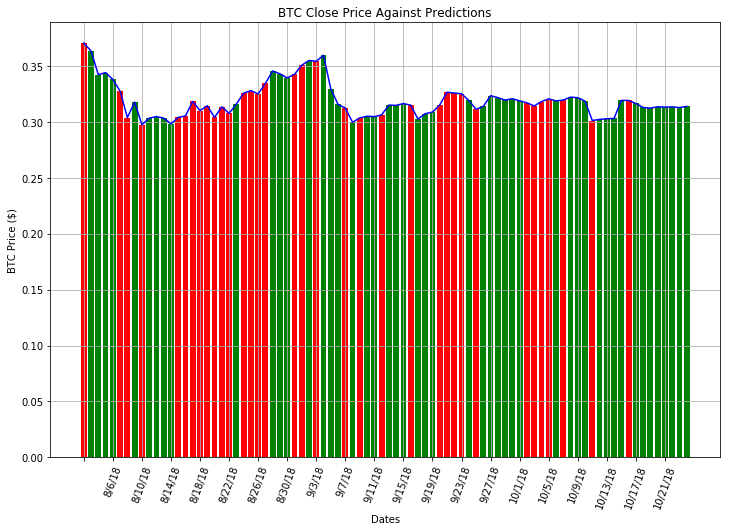


Widening centers...
Max iterations reached (250)

Adding neuron...

BUILDING SOFNN WITH 14 NEURONS
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             (None, 263)          0                                            
__________________________________________________________________________________________________
FuzzyRules (FuzzyLayer)         (None, 14)           7364        Inputs[0][0]                     
__________________________________________________________________________________________________
Normalization (NormalizedLayer) (None, 14)           0           FuzzyRules[0][0]                 
__________________________________________________________________________________________________
Weights (WeightedLayer)         (None, 14)           3696        Inputs[0][0]                     
         

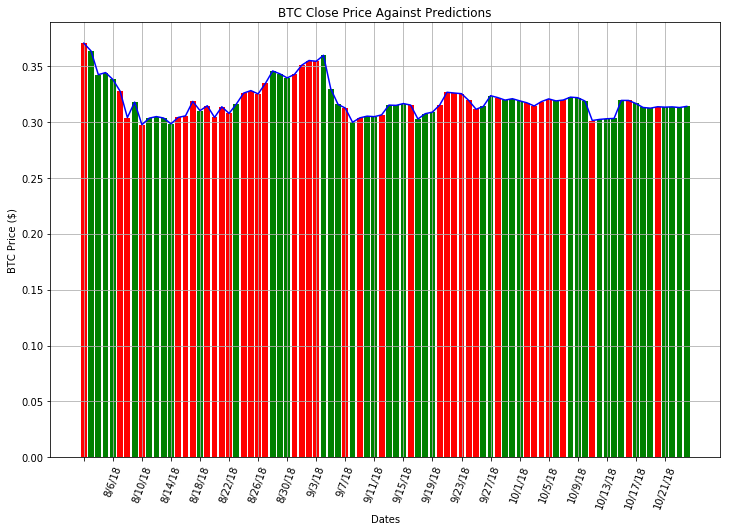


Widening centers...
Max iterations reached (250)

Adding neuron...

BUILDING SOFNN WITH 15 NEURONS
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             (None, 263)          0                                            
__________________________________________________________________________________________________
FuzzyRules (FuzzyLayer)         (None, 15)           7890        Inputs[0][0]                     
__________________________________________________________________________________________________
Normalization (NormalizedLayer) (None, 15)           0           FuzzyRules[0][0]                 
__________________________________________________________________________________________________
Weights (WeightedLayer)         (None, 15)           3960        Inputs[0][0]                     
         

C:\Anaconda3\envs\Crypto\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


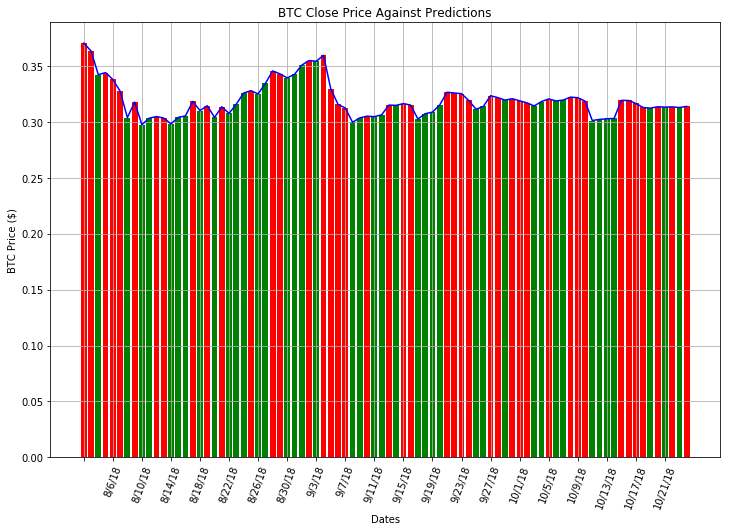

C:\Users\Admin\PycharmProjects\CryptoProject\notebooks\modeling\keras\sofenn\SOFNN.py:510: RuntimeWarning: invalid value encountered in greater_equal
  maxes = np.max(fuzz_out, axis=-1) >= self._ifpart_thresh



Widening centers...
Max iterations reached (250)

Adding neuron...

BUILDING SOFNN WITH 16 NEURONS
__________________________________________________________________________________________________

C:\Users\Admin\PycharmProjects\CryptoProject\notebooks\modeling\keras\sofenn\SOFNN.py:719: RuntimeWarning: invalid value encountered in less_equal
  ck = np.where(dist_vec <= kd_i, c_min, x.mean(axis=0))
C:\Users\Admin\PycharmProjects\CryptoProject\notebooks\modeling\keras\sofenn\SOFNN.py:720: RuntimeWarning: invalid value encountered in less_equal
  sk = np.where(dist_vec <= kd_i, s_min, dist_vec)



Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             (None, 263)          0                                            
__________________________________________________________________________________________________
FuzzyRules (FuzzyLayer)         (None, 16)           8416        Inputs[0][0]                     
__________________________________________________________________________________________________
Normalization (NormalizedLayer) (None, 16)           0           FuzzyRules[0][0]                 
__________________________________________________________________________________________________
Weights (WeightedLayer)         (None, 16)           4224        Inputs[0][0]                     
                                                                 Normalization[0][0]              
__________________________________________________________________________________________________
RawOutput

AssertionError: 

In [28]:
sofnn = SOFNN(X_train, X_test, y_train, y_test, neurons=2, 
              ksig=1.5, max_widens=250, prune_tol=0.85)
sofnn.self_organize()

### 3 Initial Neuron


BUILDING SOFNN WITH 3 NEURONS
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             (None, 263)          0                                            
__________________________________________________________________________________________________
FuzzyRules (FuzzyLayer)         (None, 3)            1578        Inputs[0][0]                     
__________________________________________________________________________________________________
Normalization (NormalizedLayer) (None, 3)            0           FuzzyRules[0][0]                 
__________________________________________________________________________________________________
Weights (WeightedLayer)         (None, 3)            792         Inputs[0][0]                     
                                                                 Normalization

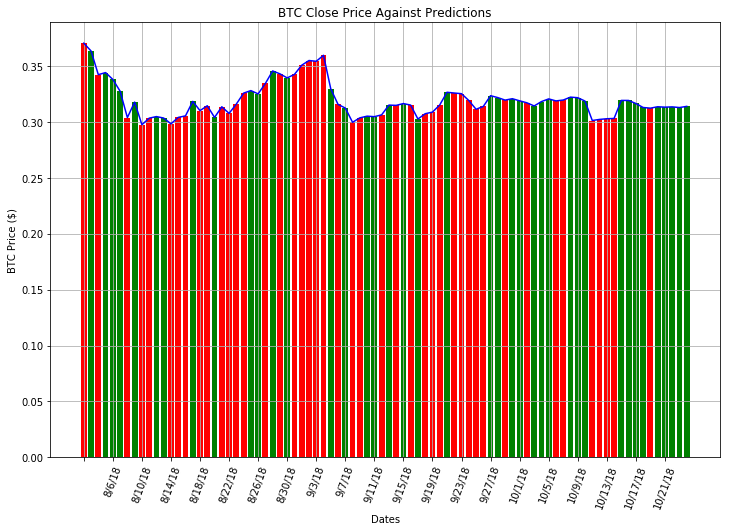


Widening centers...
Max iterations reached (250)

Adding neuron...

BUILDING SOFNN WITH 4 NEURONS
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             (None, 263)          0                                            
__________________________________________________________________________________________________
FuzzyRules (FuzzyLayer)         (None, 4)            2104        Inputs[0][0]                     
__________________________________________________________________________________________________
Normalization (NormalizedLayer) (None, 4)            0           FuzzyRules[0][0]                 
__________________________________________________________________________________________________
Weights (WeightedLayer)         (None, 4)            1056        Inputs[0][0]                     
          

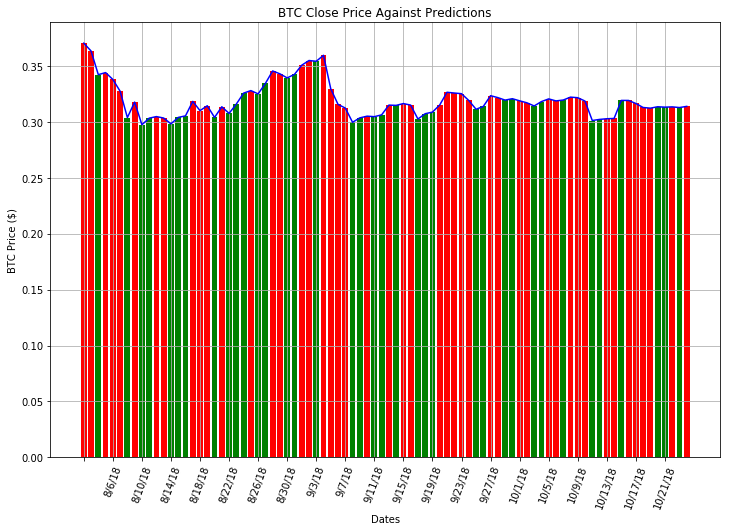


Widening centers...
Max iterations reached (250)

Adding neuron...

BUILDING SOFNN WITH 5 NEURONS
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             (None, 263)          0                                            
__________________________________________________________________________________________________
FuzzyRules (FuzzyLayer)         (None, 5)            2630        Inputs[0][0]                     
__________________________________________________________________________________________________
Normalization (NormalizedLayer) (None, 5)            0           FuzzyRules[0][0]                 
__________________________________________________________________________________________________
Weights (WeightedLayer)         (None, 5)            1320        Inputs[0][0]                     
          

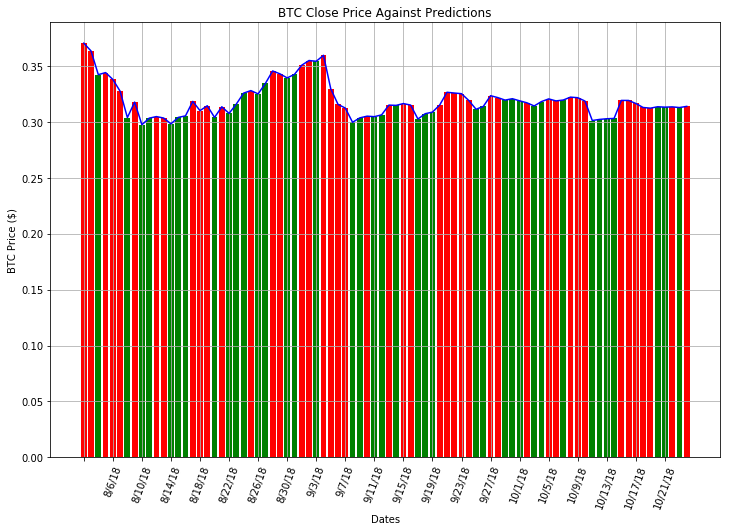


Widening centers...
Max iterations reached (250)

Adding neuron...

BUILDING SOFNN WITH 6 NEURONS
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             (None, 263)          0                                            
__________________________________________________________________________________________________
FuzzyRules (FuzzyLayer)         (None, 6)            3156        Inputs[0][0]                     
__________________________________________________________________________________________________
Normalization (NormalizedLayer) (None, 6)            0           FuzzyRules[0][0]                 
__________________________________________________________________________________________________
Weights (WeightedLayer)         (None, 6)            1584        Inputs[0][0]                     
          

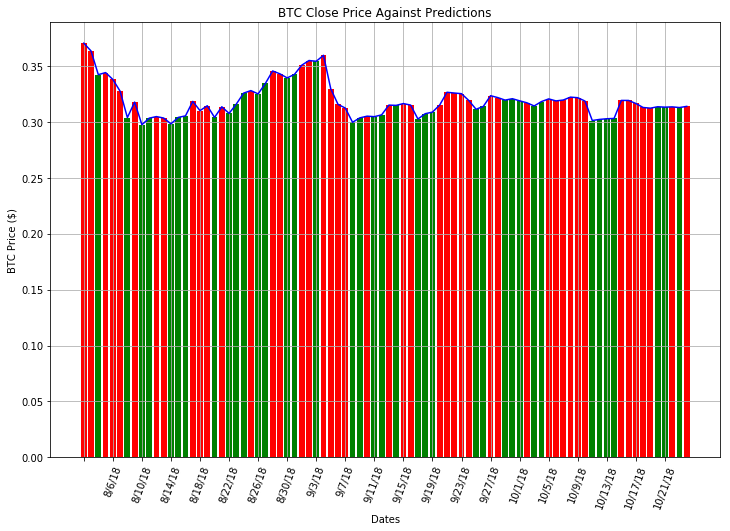


Widening centers...
Max iterations reached (250)

Adding neuron...

BUILDING SOFNN WITH 7 NEURONS
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             (None, 263)          0                                            
__________________________________________________________________________________________________
FuzzyRules (FuzzyLayer)         (None, 7)            3682        Inputs[0][0]                     
__________________________________________________________________________________________________
Normalization (NormalizedLayer) (None, 7)            0           FuzzyRules[0][0]                 
__________________________________________________________________________________________________
Weights (WeightedLayer)         (None, 7)            1848        Inputs[0][0]                     
          

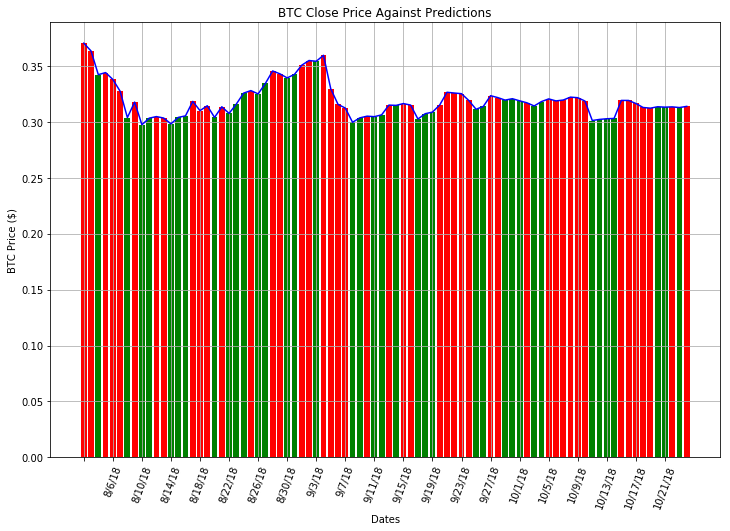


Widening centers...
Max iterations reached (250)

Adding neuron...

BUILDING SOFNN WITH 8 NEURONS
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             (None, 263)          0                                            
__________________________________________________________________________________________________
FuzzyRules (FuzzyLayer)         (None, 8)            4208        Inputs[0][0]                     
__________________________________________________________________________________________________
Normalization (NormalizedLayer) (None, 8)            0           FuzzyRules[0][0]                 
__________________________________________________________________________________________________
Weights (WeightedLayer)         (None, 8)            2112        Inputs[0][0]                     
          

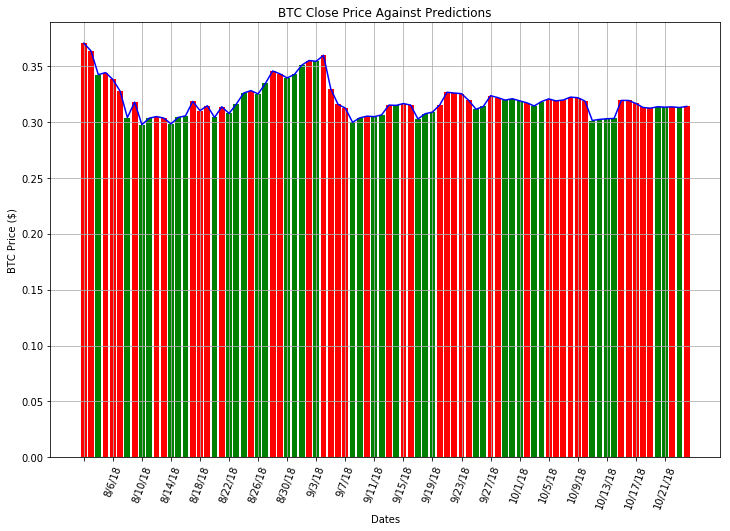


Widening centers...
Max iterations reached (250)

Adding neuron...

BUILDING SOFNN WITH 9 NEURONS
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             (None, 263)          0                                            
__________________________________________________________________________________________________
FuzzyRules (FuzzyLayer)         (None, 9)            4734        Inputs[0][0]                     
__________________________________________________________________________________________________
Normalization (NormalizedLayer) (None, 9)            0           FuzzyRules[0][0]                 
__________________________________________________________________________________________________
Weights (WeightedLayer)         (None, 9)            2376        Inputs[0][0]                     
          

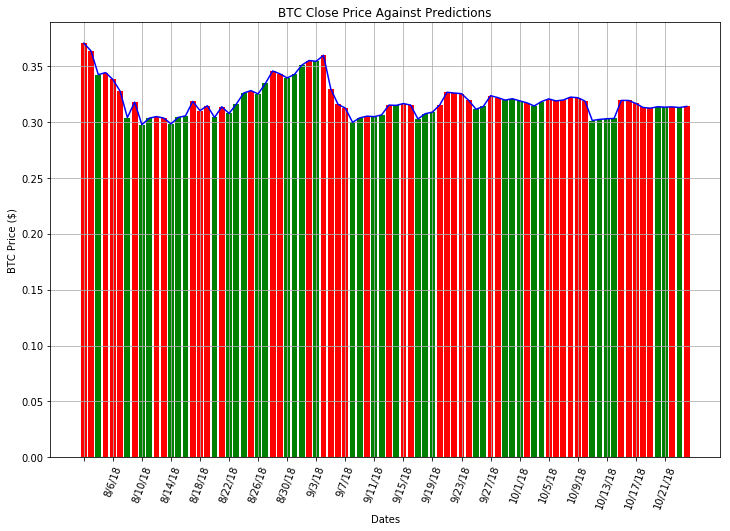


Widening centers...
Max iterations reached (250)

Adding neuron...

BUILDING SOFNN WITH 10 NEURONS
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             (None, 263)          0                                            
__________________________________________________________________________________________________
FuzzyRules (FuzzyLayer)         (None, 10)           5260        Inputs[0][0]                     
__________________________________________________________________________________________________
Normalization (NormalizedLayer) (None, 10)           0           FuzzyRules[0][0]                 
__________________________________________________________________________________________________
Weights (WeightedLayer)         (None, 10)           2640        Inputs[0][0]                     
         

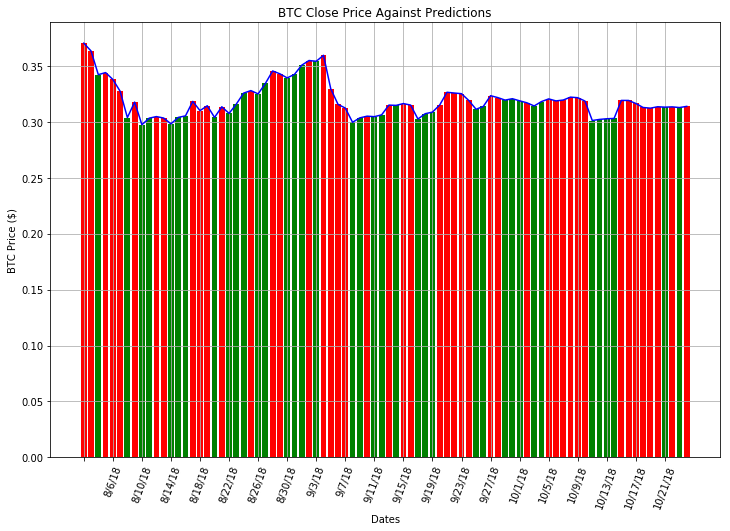


Widening centers...
Max iterations reached (250)

Adding neuron...

BUILDING SOFNN WITH 11 NEURONS
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             (None, 263)          0                                            
__________________________________________________________________________________________________
FuzzyRules (FuzzyLayer)         (None, 11)           5786        Inputs[0][0]                     
__________________________________________________________________________________________________
Normalization (NormalizedLayer) (None, 11)           0           FuzzyRules[0][0]                 
__________________________________________________________________________________________________
Weights (WeightedLayer)         (None, 11)           2904        Inputs[0][0]                     
         

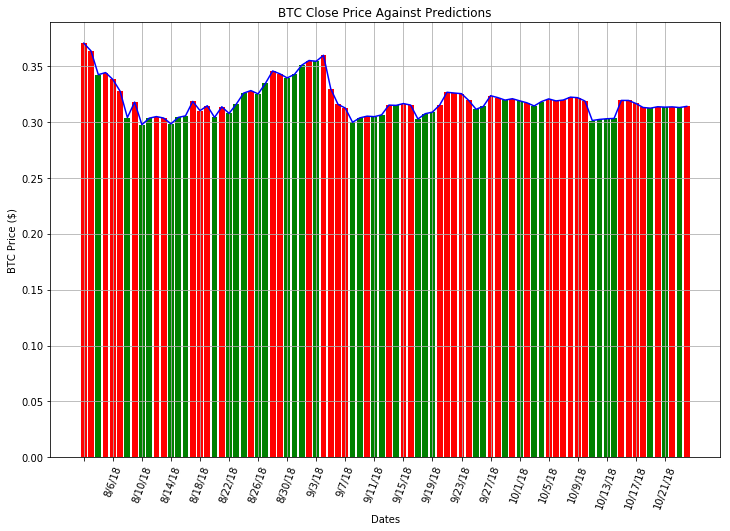


Widening centers...
Max iterations reached (250)

Adding neuron...

BUILDING SOFNN WITH 12 NEURONS
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             (None, 263)          0                                            
__________________________________________________________________________________________________
FuzzyRules (FuzzyLayer)         (None, 12)           6312        Inputs[0][0]                     
__________________________________________________________________________________________________
Normalization (NormalizedLayer) (None, 12)           0           FuzzyRules[0][0]                 
__________________________________________________________________________________________________
Weights (WeightedLayer)         (None, 12)           3168        Inputs[0][0]                     
         

C:\Anaconda3\envs\Crypto\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


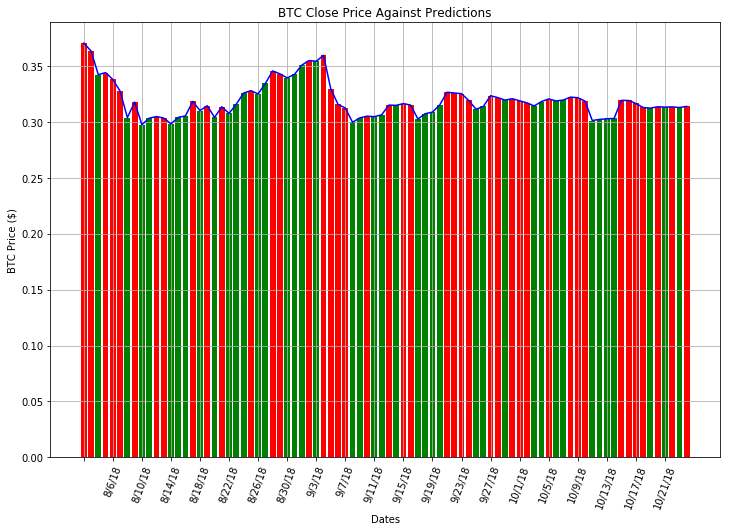

C:\Users\Admin\PycharmProjects\CryptoProject\notebooks\modeling\keras\sofenn\SOFNN.py:510: RuntimeWarning: invalid value encountered in greater_equal
  maxes = np.max(fuzz_out, axis=-1) >= self._ifpart_thresh



Widening centers...
Max iterations reached (250)

Adding neuron...

BUILDING SOFNN WITH 13 NEURONS
__________________________________________________________________________________________________

C:\Users\Admin\PycharmProjects\CryptoProject\notebooks\modeling\keras\sofenn\SOFNN.py:719: RuntimeWarning: invalid value encountered in less_equal
  ck = np.where(dist_vec <= kd_i, c_min, x.mean(axis=0))
C:\Users\Admin\PycharmProjects\CryptoProject\notebooks\modeling\keras\sofenn\SOFNN.py:720: RuntimeWarning: invalid value encountered in less_equal
  sk = np.where(dist_vec <= kd_i, s_min, dist_vec)



Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             (None, 263)          0                                            
__________________________________________________________________________________________________
FuzzyRules (FuzzyLayer)         (None, 13)           6838        Inputs[0][0]                     
__________________________________________________________________________________________________
Normalization (NormalizedLayer) (None, 13)           0           FuzzyRules[0][0]                 
__________________________________________________________________________________________________
Weights (WeightedLayer)         (None, 13)           3432        Inputs[0][0]                     
                                                                 Normalization[0][0]              
__________________________________________________________________________________________________
RawOutput

AssertionError: 

In [29]:
sofnn = SOFNN(X_train, X_test, y_train, y_test, neurons=3, 
              ksig=1.5, max_widens=250, prune_tol=0.85)
sofnn.self_organize()

### 5 Initial Neuron

In [ ]:
sofnn = SOFNN(X_train, X_test, y_train, y_test, neurons=5, 
              ksig=1.5, max_widens=250, prune_tol=0.85)
sofnn.self_organize()

### 10 Initial Neuron

In [ ]:
sofnn = SOFNN(X_train, X_test, y_train, y_test, neurons=10, 
              ksig=1.5, max_widens=250, prune_tol=0.85)
sofnn.self_organize()

### 20 Initial Neuron

In [ ]:
sofnn = SOFNN(X_train, X_test, y_train, y_test, neurons=20, 
              ksig=1.5, max_widens=250, prune_tol=0.85)
sofnn.self_organize()

### 25 Initial Neuron

In [ ]:
sofnn = SOFNN(X_train, X_test, y_train, y_test, neurons=25, 
              ksig=1.5, max_widens=250, prune_tol=0.85)
sofnn.self_organize()

### 50 Initial Neuron

In [ ]:
sofnn = SOFNN(X_train, X_test, y_train, y_test, neurons=50, 
              ksig=1.5, max_widens=250, prune_tol=0.85)
sofnn.self_organize()